In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pip install skforecast

In [2]:
# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

In [3]:
df = pd.read_excel("C:\\Users\\Lenovo\\Downloads\\test.xlsx", sheet_name='pid = 8 daily')
df.head()

,order_date,product_id,quantities_sold
0,2019-09-01,8,4.0
1,2019-09-02,8,0.0
2,2019-09-03,8,1.0
3,2019-09-04,8,0.0
4,2019-09-05,8,0.0


In [4]:
df['order_date'] = pd.to_datetime(df['order_date'], format='%d/%m/%Y')
df = df.set_index('order_date')
df = df.asfreq('MS')
df = df.sort_index()
df.head()

,product_id,quantities_sold
order_date,,
2019-09-01,8,4.0
2019-10-01,8,0.0
2019-11-01,8,1.0
2019-12-01,8,10.0
2020-01-01,8,17.0


In [6]:
# Verify that a temporary index is complete
# ==============================================================================
(df.index == pd.date_range(start=df.index.min(),end=df.index.max(),freq=df.index.freq)).all()

True

In [ ]:
# Split data into train-test
# ==============================================================================
steps = 5
data_train = df[:-steps]
data_test  = df[-steps:]

fig, ax=plt.subplots(figsize=(9, 4))
data_train['quantities_sold'].plot(ax=ax, label='train')
data_test['quantities_sold'].plot(ax=ax, label='test')
ax.legend();

In [8]:
#Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123), lags = 6)

forecaster.fit(y=data_train['quantities_sold'])

forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Window size: 6 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2019-09-01 00:00:00'), Timestamp('2021-07-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-03-16 22:53:09 
Last fit date: 2022-03-16 22:53:11 
Skforecast version: 0.4.2 

In [10]:
# Predictions
# ==============================================================================
steps = 5
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2021-08-01    144.11
2021-09-01    145.70
2021-10-01    137.36
2021-11-01    145.19
2021-12-01    142.74
Freq: MS, Name: pred, dtype: float64

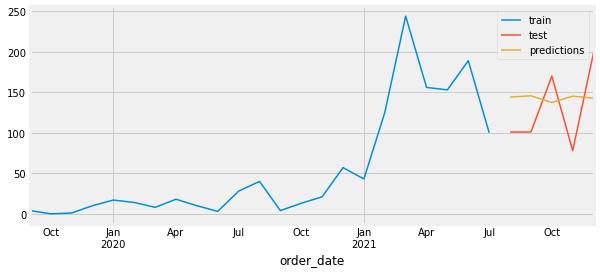

In [11]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['quantities_sold'].plot(ax=ax, label='train')
data_test['quantities_sold'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [12]:
# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['quantities_sold'],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 2520.323079999999


In [ ]:
# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

# Lags used as predictors
lags_grid = [10, 20]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['quantities_sold'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 5,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        return_best        = True,
                        verbose            = False
                   )

In [ ]:
# Grid Search results
# ==============================================================================
results_grid

In [17]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)

forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=data_train['quantities_sold'])

In [ ]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['qunatities_sold'].plot(ax=ax, label='train')
data_test['qunatities_sold'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [20]:
# Error de test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['quantities_sold'],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 2520.323079999999
